# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link:

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170M/170M [00:16<00:00, 10.3MB/s]


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

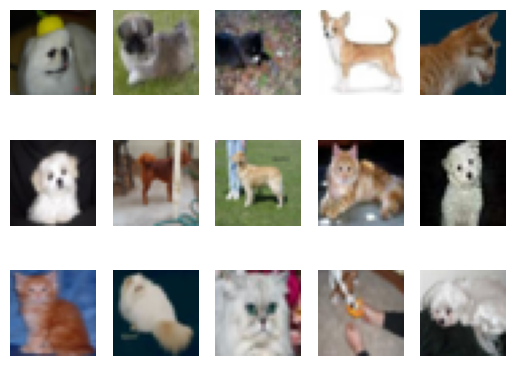

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
# Create data loaders with batch size 64
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

# Calculate the number of samples in each dataset
train_size = len(train_loader.sampler)
val_size = len(val_loader.sampler)
test_size = len(test_loader.sampler)

print(f"Training examples: {train_size}")
print(f"Validation examples: {val_size}")
print(f"Test examples: {test_size}")

Training examples: 8000
Validation examples: 2000
Test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
"""
We need a validation set as an independent dataset to evaluate model performance during training without using the test set.
It helps us monitor overfitting by compaing training to validation performance, tune hyperparameters,
and decide when to stop training.
If we only use training set loss/error, hte model will results in better performance since it has seen this data before.
But this is not meaningful because the model might mamorize rather than learn patterns.
"""

'\nWe need a validation set as an independent dataset to evaluate model performance during training without using the test set.\nIt helps us monitor overfitting by compaing training to validation performance, tune hyperparameters,\nand decide when to stop training.\nIf we only use training set loss/error, hte model will results in better performance since it has seen this data before.\nBut this is not meaningful because the model might mamorize rather than learn patterns.\n'

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small_total = 0
for param in small_net.parameters():
    param_count = param.numel()  # Number of elements in tensor
    small_total += param_count

print(f"\nTotal parameters in SmallNet: {small_total}")

large_total = 0
for param in large_net.parameters():
    param_count = param.numel()  # Number of elements in tensor
    large_total += param_count

print(f"\nTotal parameters in LargeNet: {large_total}")


Total parameters in SmallNet: 386

Total parameters in LargeNet: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
"""
As defined in the first line of the code,
the default values of the parameters are:
batch_size = 64
learning_rate = 0.01
num_epochs = 30
"""

'\nAs defined in the first line of the code,\nthe default values of the parameters are:\nbatch_size = 64\nlearning_rate = 0.01\nnum_epochs = 30\n'

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
"""
The files written to disk are:
Checkpoint files
- model_small_bs64_lr0.01_epoch1.pth
- model_small_bs64_lr0.01_epoch2.pth
- model_small_bs64_lr0.01_epoch3.pth
- model_small_bs64_lr0.01_epoch4.pth
- model_small_bs64_lr0.01_epoch5.pth
Csv log files
- model_small_bs64_lr0.01_epoch5.pth_train_err.csv
- model_small_bs64_lr0.01_epoch5.pth_train_loss.csv
- model_small_bs64_lr0.01_epoch5.pth_val_err.csv
- model_small_bs64_lr0.01_epoch5.pth_val_loss.csv

Checkpoint files contain the model's parameters (ie weights and biases) at the end of each epoch.
Each csv log file contains a list of numbers, one for each epoch,recording how error or loss changed over taining.
"""

"\nThe files written to disk are:\nCheckpoint files\n- model_small_bs64_lr0.01_epoch1.pth\n- model_small_bs64_lr0.01_epoch2.pth\n- model_small_bs64_lr0.01_epoch3.pth\n- model_small_bs64_lr0.01_epoch4.pth\n- model_small_bs64_lr0.01_epoch5.pth\nCsv log files\n- model_small_bs64_lr0.01_epoch5.pth_train_err.csv\n- model_small_bs64_lr0.01_epoch5.pth_train_loss.csv\n- model_small_bs64_lr0.01_epoch5.pth_val_err.csv\n- model_small_bs64_lr0.01_epoch5.pth_val_loss.csv\n\nCheckpoint files contain the model's parameters (ie weights and biases) at the end of each epoch.\nEach csv log file contains a list of numbers, one for each epoch,recording how error or loss changed over taining.\n"

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Epoch 1: Train err: 0.46325, Train loss: 0.6859865365028381 |Validation err: 0.4005, Validation loss: 0.6672044675797224
Epoch 2: Train err: 0.381375, Train loss: 0.6547599444389344 |Validation err: 0.391, Validation loss: 0.6664604302495718
Epoch 3: Train err: 0.35425, Train loss: 0.6328138070106506 |Validation err: 0.344, Validation loss: 0.6272639129310846
Epoch 4: Train err: 0.33725, Train loss: 0.6170017013549804 |Validation err: 0.3685, Validation loss: 0.6348218880593777
Epoch 5: Train err: 0.32625, Train loss: 0.6053644914627075 |Validation err: 0.3325, Validation loss: 0.6217041872441769
Epoch 6: Train err: 0.3165, Train loss: 0.5954686350822449 |Validation err: 0.3335, Validation loss: 0.6210461277514696
Epoch 7: Train err: 0.311625, Train loss: 0.5916003460884094 |Validation err: 0.3335, Validation loss: 0.6115647591650486
Epoch 8: Train err: 0.306625, Train loss: 0.5865035443305969 |Validation err: 0.32, Validation loss: 0.608370453119278
Epoch 9: Train err: 0.3125, Train l

In [ ]:
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Epoch 1: Train err: 0.467625, Train loss: 0.6902394351959229 |Validation err: 0.436, Validation loss: 0.6789459083229303
Epoch 2: Train err: 0.432375, Train loss: 0.6801531429290771 |Validation err: 0.4185, Validation loss: 0.6802953220903873
Epoch 3: Train err: 0.401375, Train loss: 0.6669564080238343 |Validation err: 0.3735, Validation loss: 0.6517238952219486
Epoch 4: Train err: 0.36975, Train loss: 0.6459191279411316 |Validation err: 0.3595, Validation loss: 0.6435045804828405
Epoch 5: Train err: 0.349125, Train loss: 0.6278092436790467 |Validation err: 0.333, Validation loss: 0.6211869586259127
Epoch 6: Train err: 0.33625, Train loss: 0.6099254283905029 |Validation err: 0.323, Validation loss: 0.616051291115582
Epoch 7: Train err: 0.3195, Train loss: 0.5945939683914184 |Validation err: 0.3205, Validation loss: 0.6045173741877079
Epoch 8: Train err: 0.305375, Train loss: 0.574511103630066 |Validation err: 0.328, Validation loss: 0.5997961973771453
Epoch 9: Train err: 0.304, Train l

In [ ]:
"""
Training small_net took about 147 seconds while training large_net took about seconds.
large_nnet took longer to train because it has more parameters (9705 vs 386).
The larger number of convolutional filters and fully connected weights increases
the computation per foward and backward pass resulting, in longer runtime.
"""

'\nTraining small_net took about 147 seconds while training large_net took about seconds.\nlarge_nnet took longer to train because it has more parameters (9705 vs 386).\nThe larger number of convolutional filters and fully connected weights increases\nthe computation per foward and backward pass resulting, in longer runtime.\n'

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

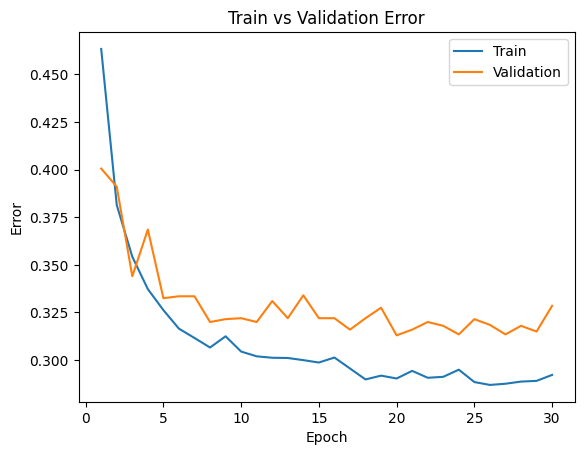

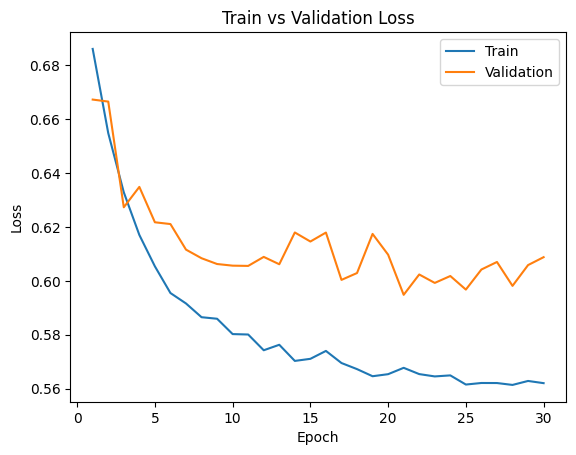

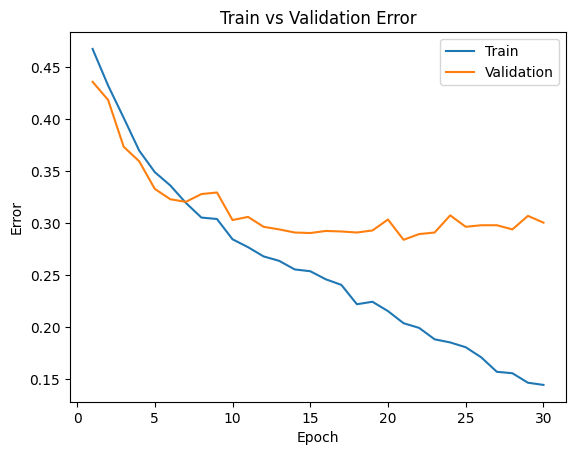

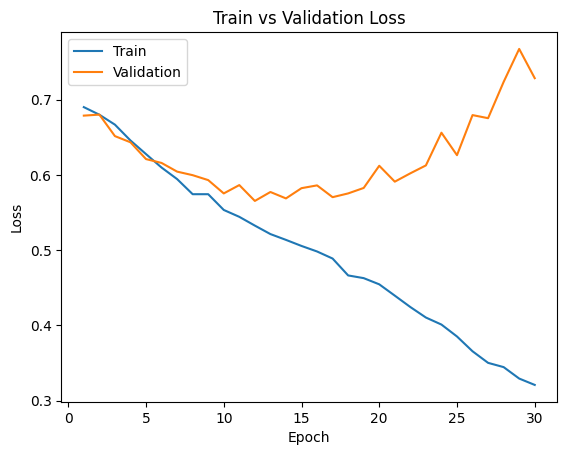

In [ ]:
# SmallNet
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)

# LargeNet
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
"""
For small net, both the raining and validation errors remain relatively high, and training loss decreases only a little from 0.66 to 0.56.
This indicates underfitting since the model lacks capacity to fit the data.
For large net, the training error and loss decreases much more rapidly, but the validation error increases after some epochs are done.
This indicates overfitting, where the model memorizes the training data instead of learning patterns.
"""

'\nFor small net, both the raining and validation errors remain relatively high, and training loss decreases only a little from 0.66 to 0.56.\nThis indicates underfitting since the model lacks capacity to fit the data.\nFor large net, the training error and loss decreases much more rapidly, but the validation error increases after some epochs are done.\nThis indicates overfitting, where the model memorizes the training data instead of learning patterns.\n'

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589716911316 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067404747009 |Validation err: 0.4285, Validation loss: 0.6908544525504112
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.68965969607234
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419748306275 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267811775207 |Validation err: 0.4115, Validation loss: 0.6831991244107485
Epoch 9: Train err: 0.424375, Tr

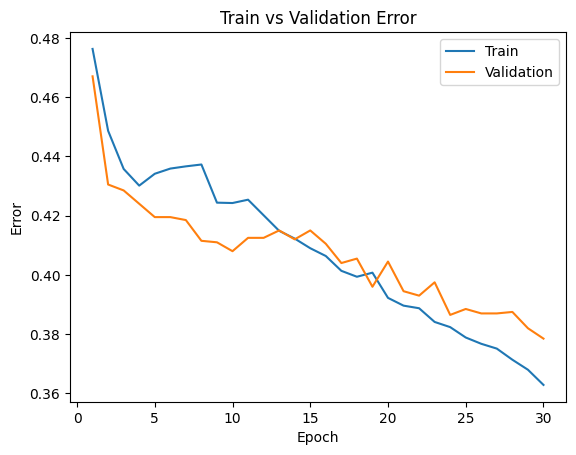

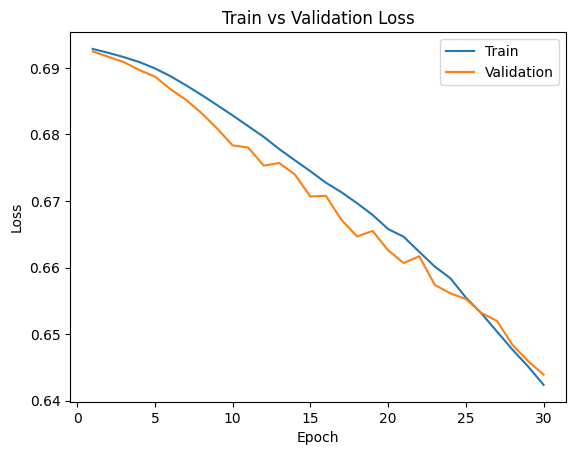

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

model_path_large_lr001 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large_lr001)

In [ ]:
"""
The loss decreased very slowly and the validation error remained high (around 36% miclassification).
This indicates that with a learning rate of 0.001, the model is underfitting,
since it has not learned the training data sufficiently even after 30 epochs.
A too-small learning rate may cause the optimizer to get stuck in local minimum
or move too slowly across flat regions of the loss surface.
"""

'\nThe loss decreased very slowly and the validation error remained high (around 36% miclassification).\nThis indicates that with a learning rate of 0.001, the model is underfitting,\nsince it has not learned the training data sufficiently even after 30 epochs.\nA too-small learning rate may cause the optimizer to get stuck in local minimum\nor move too slowly across flat regions of the loss surface.\n'

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Epoch 1: Train err: 0.4295, Train loss: 0.6743808445930481 |Validation err: 0.3565, Validation loss: 0.6350402887910604
Epoch 2: Train err: 0.36925, Train loss: 0.6415545463562011 |Validation err: 0.3515, Validation loss: 0.6243696268647909
Epoch 3: Train err: 0.366, Train loss: 0.6304733338356018 |Validation err: 0.3475, Validation loss: 0.6173483617603779
Epoch 4: Train err: 0.35775, Train loss: 0.6251179370880127 |Validation err: 0.3345, Validation loss: 0.620793430134654
Epoch 5: Train err: 0.33675, Train loss: 0.6045795600414277 |Validation err: 0.329, Validation loss: 0.5937281344085932
Epoch 6: Train err: 0.31775, Train loss: 0.5828781847953797 |Validation err: 0.3275, Validation loss: 0.6041664052754641
Epoch 7: Train err: 0.3195, Train loss: 0.5794640259742737 |Validation err: 0.334, Validation loss: 0.6052154619246721
Epoch 8: Train err: 0.311875, Train loss: 0.5757701637744903 |Validation err: 0.318, Validation loss: 0.5993684772402048
Epoch 9: Train err: 0.29325, Train loss

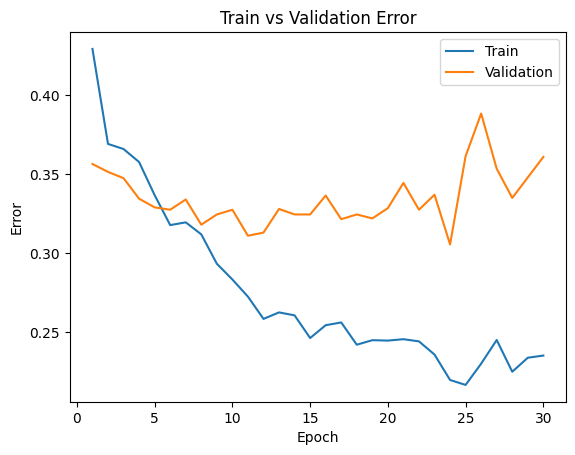

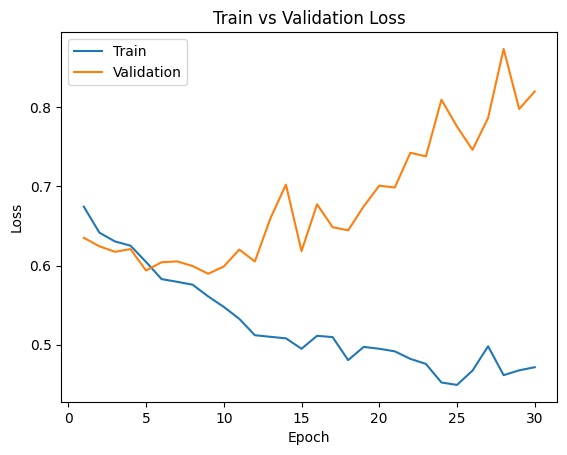

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

model_path_large_lr001 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large_lr001)

In [ ]:
"""
With a learning rate of 0.1, the training decreased quickly, but the validation error increased to around 35% and even worsened in lator epochs.
Similarly, while training loss steadily decreased, validation loss began to rise after about 10 epochs. This indicates overfitting
as the high learning rate causes the optimizer to overshoot the optimal region the loss surface.
"""

'\nWith a learning rate of 0.1, the training decreased quickly, but the validation error increased to around 35% and even worsened in lator epochs. \nSimilarly, while training loss steadily decreased, validation loss began to rise after about 10 epochs. This indicates overfitting \nas the high learning rate causes the optimizer to overshoot the optimal region the loss surface.\n'

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.692410409450531 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770620465279 |Validation err: 0.411, Validation loss: 0.6814672648906708
Epoch 9: Train err: 0.42375, Train loss: 0.

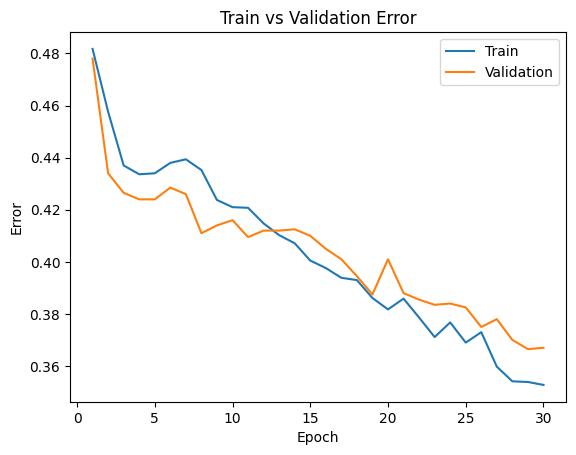

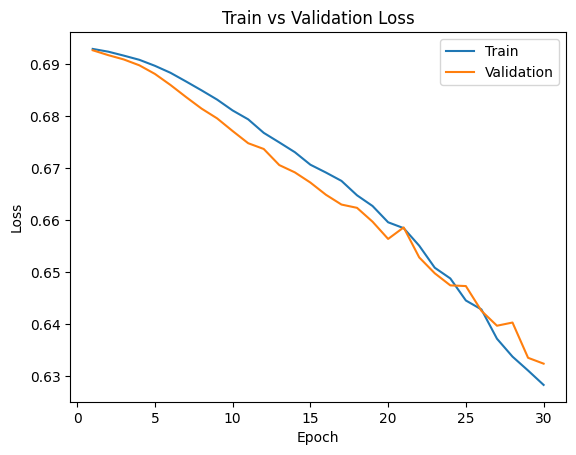

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

model_path_large_batch512 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_batch512)

In [ ]:
"""
Training and validation cuvrves were smoother but the model trained more slowly
because there were fewer parameter updates per epoch.
"""

'\nTraining and validation cuvrves were smoother but the model trained more slowly \nbecause there were fewer parameter updates per epoch.\n'

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Epoch 1: Train err: 0.432625, Train loss: 0.6775506126880646 |Validation err: 0.378, Validation loss: 0.6512571973800659
Epoch 2: Train err: 0.366375, Train loss: 0.6387728816270828 |Validation err: 0.337, Validation loss: 0.612742235660553
Epoch 3: Train err: 0.339375, Train loss: 0.6119522891640663 |Validation err: 0.345, Validation loss: 0.6396356213092804
Epoch 4: Train err: 0.312125, Train loss: 0.5861616842746734 |Validation err: 0.3375, Validation loss: 0.6223122742176056
Epoch 5: Train err: 0.309125, Train loss: 0.5655454085469246 |Validation err: 0.303, Validation loss: 0.5682719912528992
Epoch 6: Train err: 0.283875, Train loss: 0.546434996843338 |Validation err: 0.3125, Validation loss: 0.581913836479187
Epoch 7: Train err: 0.275625, Train loss: 0.5315411986708641 |Validation err: 0.3185, Validation loss: 0.5755203785896301
Epoch 8: Train err: 0.253625, Train loss: 0.5110043309926987 |Validation err: 0.326, Validation loss: 0.6016001827716827
Epoch 9: Train err: 0.249375, Tr

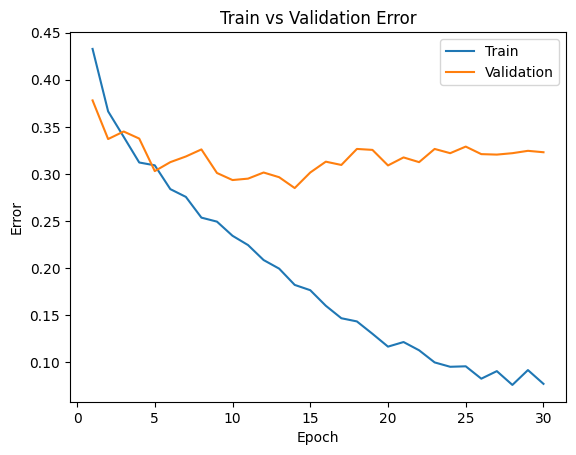

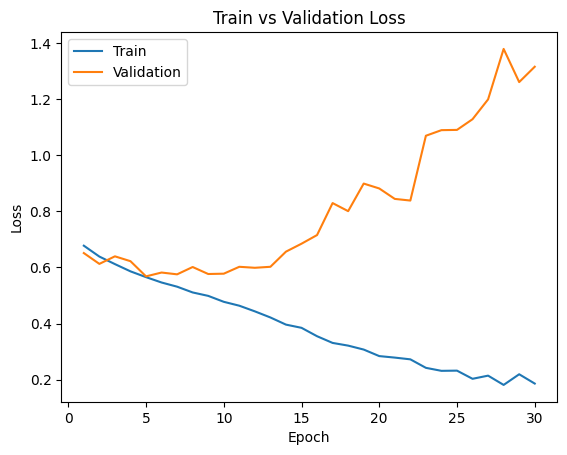

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

model_path_large_batch16 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_batch16)

In [ ]:
"""
Training converged faster but the error curves were noisier and
the model showed a high risk of overfitting due to the noisy gradient updates.
"""

'\nTraining converged faster but the error curves were noisier and \nthe model showed a high risk of overfitting due to the noisy gradient updates. \n'

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
"""
The best model I choose was LargeNet with batch size =512, learning rate = 0.001,
and trained for around the epoch where the validation error was lowest.
This configuration achieved the best balance between training and validation performance without severe overfitting.
"""

'\nThe best model I choose was LargeNet with batch size =512, learning rate = 0.001,\nand trained for around the epoch where the validation error was lowest.\nThis configuration achieved the best balance between training and validation performance without severe overfitting.\n'

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Epoch 1: Train err: 0.5005, Train loss: 0.6991336531937122 |Validation err: 0.4925, Validation loss: 0.6945076286792755
Epoch 2: Train err: 0.48, Train loss: 0.6934637613594532 |Validation err: 0.4755, Validation loss: 0.6918978244066238
Epoch 3: Train err: 0.48175, Train loss: 0.6918338723480701 |Validation err: 0.465, Validation loss: 0.691420242190361
Epoch 4: Train err: 0.472375, Train loss: 0.6913324221968651 |Validation err: 0.4645, Validation loss: 0.6911140084266663
Epoch 5: Train err: 0.469125, Train loss: 0.6907239854335785 |Validation err: 0.4565, Validation loss: 0.6905251443386078
Epoch 6: Train err: 0.466875, Train loss: 0.690356221050024 |Validation err: 0.459, Validation loss: 0.6900540739297867
Epoch 7: Train err: 0.4635, Train loss: 0.6899680756032467 |Validation err: 0.4625, Validation loss: 0.6895745247602463
Epoch 8: Train err: 0.461, Train loss: 0.6896125338971615 |Validation err: 0.4605, Validation loss: 0.6891213655471802
Epoch 9: Train err: 0.455625, Train loss

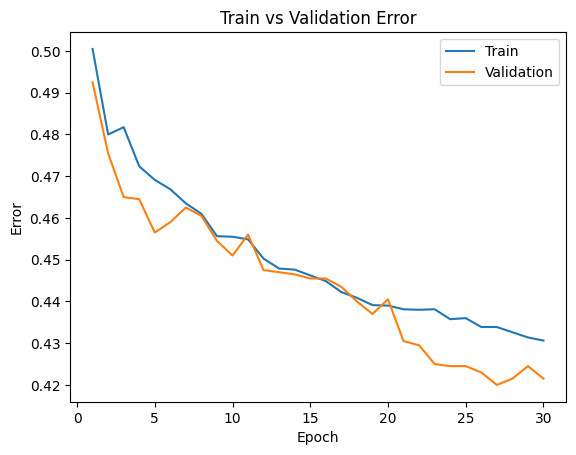

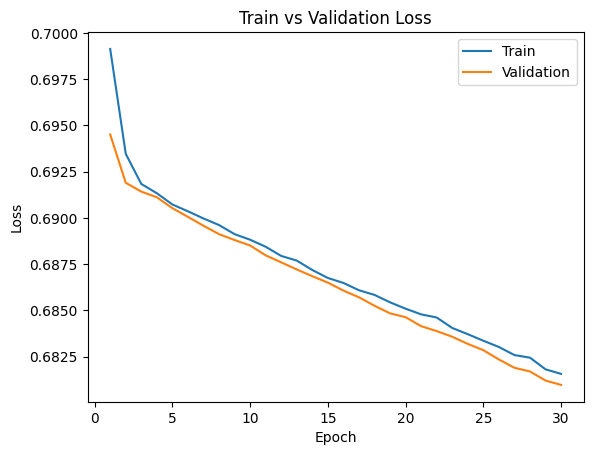

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=512, learning_rate=0.001, num_epochs=30)

model_path_small = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_small)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
"""
I chose to try LargeNet with batch size =128, learning rate = 0.005,
Compared to the previous setup, a slightly larger batch size should
produce smooother gradient updates and reduce overfitting, while
lowering the learning rate allows the model to converge more gradually
and potentially reach a better minimum. This combination may improve
validation accuracy while maintaining training stability.
"""

'\nI chose to try LargeNet with batch size =128, learning rate = 0.005,\nCompared to the previous setup, a slightly larger batch size should\nproduce smooother gradient updates and reduce overfitting, while\nlowering the learning rate allows the model to converge more gradually\nand potentially reach a better minimum. This combination may improve\nvalidation accuracy while maintaining training stability.\n'

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Epoch 1: Train err: 0.466625, Train loss: 0.6925613293572078 |Validation err: 0.4305, Validation loss: 0.6916250362992287
Epoch 2: Train err: 0.45025, Train loss: 0.6910345800339229 |Validation err: 0.4295, Validation loss: 0.6889703124761581
Epoch 3: Train err: 0.430375, Train loss: 0.6885879314134992 |Validation err: 0.4165, Validation loss: 0.6849973574280739
Epoch 4: Train err: 0.430625, Train loss: 0.685001117842538 |Validation err: 0.4125, Validation loss: 0.6797145418822765
Epoch 5: Train err: 0.42075, Train loss: 0.6813914756926279 |Validation err: 0.4105, Validation loss: 0.6762874536216259
Epoch 6: Train err: 0.416125, Train loss: 0.677302136307671 |Validation err: 0.4125, Validation loss: 0.6729768812656403
Epoch 7: Train err: 0.405, Train loss: 0.6732375101437644 |Validation err: 0.4055, Validation loss: 0.6696236506104469
Epoch 8: Train err: 0.400375, Train loss: 0.6694215252285912 |Validation err: 0.402, Validation loss: 0.6651131212711334
Epoch 9: Train err: 0.390625, Tr

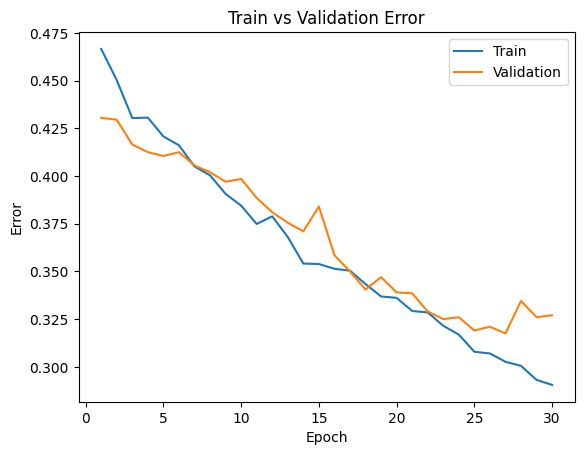

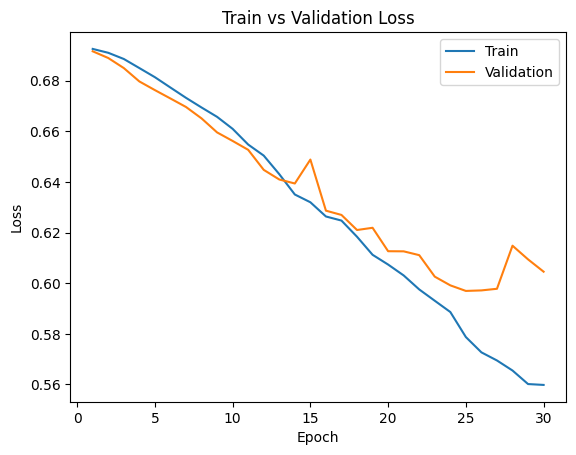

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=128, learning_rate=0.005, num_epochs=30)

model_path_large = get_model_name("large", batch_size=128, learning_rate=0.005, epoch=29)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
"""
I chose LargeNet with batch size = 128, learning rate = 0.005, and epoch = 29 as my best model
because it achieved one of the lowest validation errors (~0.326) with a stable validation loss (~0.604).
Compared to other configurations, this setup provided a good balance between fast convergence and generalization.
The slightly larger batch size (128 vs 64) produced smoother gradient updates, and rising the learning rate (0.005 vs 0.001)
helped the model converge more gradually without overshooting. As a result, the validation performance was more stable
and showed less overfitting than other tested models.
"""

'\nI chose LargeNet with batch size = 128, learning rate = 0.005, and epoch = 29 as my best model\nbecause it achieved one of the lowest validation errors (~0.326) with a stable validation loss (~0.604).\nCompared to other configurations, this setup provided a good balance between fast convergence and generalization.\nThe slightly larger batch size (128 vs 64) produced smoother gradient updates, and rising the learning rate (0.005 vs 0.001)\nhelped the model converge more gradually without overshooting. As a result, the validation performance was more stable\nand showed less overfitting than other tested models.\n'

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("Test err: {}, Test loss: {}".format(test_err, test_loss))

Test err: 0.311, Test loss: 0.5827860767021775


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
"""
The test classification error (0.311) is slightly lower than the validation error (0.326) for this model.
Usually, we expect the test error to be slightly higher than the validation error because the test set is completely unseen
during training and hyperparameter tunning.
"""

'\nThe test classification error (0.311) is slightly lower than the validation error (0.326) for this model.\nUsually, we expect the test error to be slightly higher than the validation error because the test set is completely unseen\nduring training and hyperparameter tunning.\n'

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
"""
We only used the test dataset at very end to ensure it remained a truly independent evalutaion of our model's performance.
If we had used the test set repeatedly during training or hyperparameter tuning, we would risk indirecly fitting to the
test data, which would give an overly optimistic estimate of the model's performance on unseen data.By keeping the test data
untouched until the final evaluation, we can obtain properly learned result instead of memorized one.
"""

"\nWe only used the test dataset at very end to ensure it remained a truly independent evalutaion of our model's performance.\nIf we had used the test set repeatedly during training or hyperparameter tuning, we would risk indirecly fitting to the\ntest data, which would give an overly optimistic estimate of the model's performance on unseen data.By keeping the test data\nuntouched until the final evaluation, we can obtain properly learned result instead of memorized one.\n"

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Epoch 1: Train err: 0.406, Train loss: 0.6624030084609985 |Validation err: 0.374, Validation loss: 0.6467180009931326
Epoch 2: Train err: 0.3645, Train loss: 0.6355565705299377 |Validation err: 0.394, Validation loss: 0.6567639224231243
Epoch 3: Train err: 0.3505, Train loss: 0.6215355091094971 |Validation err: 0.3705, Validation loss: 0.6416232865303755
Epoch 4: Train err: 0.334375, Train loss: 0.608570716381073 |Validation err: 0.385, Validation loss: 0.6550784800201654
Epoch 5: Train err: 0.31925, Train loss: 0.5914316051006318 |Validation err: 0.3795, Validation loss: 0.6427767965942621
Epoch 6: Train err: 0.297, Train loss: 0.5689457640647888 |Validation err: 0.3885, Validation loss: 0.6792671028524637
Epoch 7: Train err: 0.287, Train loss: 0.5564139924049377 |Validation err: 0.3805, Validation loss: 0.6570900976657867
Epoch 8: Train err: 0.264875, Train loss: 0.5301893384456634 |Validation err: 0.3645, Validation loss: 0.6730466075241566
Epoch 9: Train err: 0.257125, Train loss: 

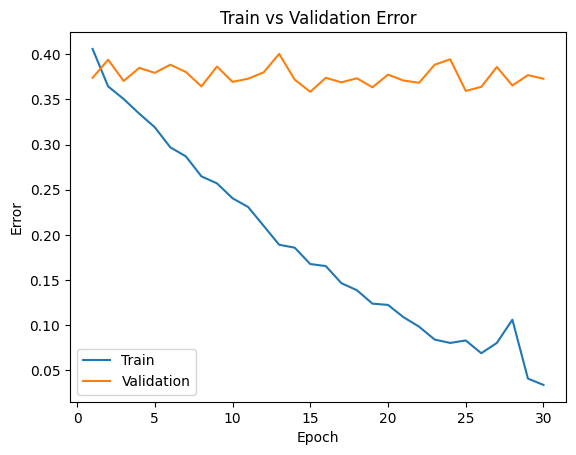

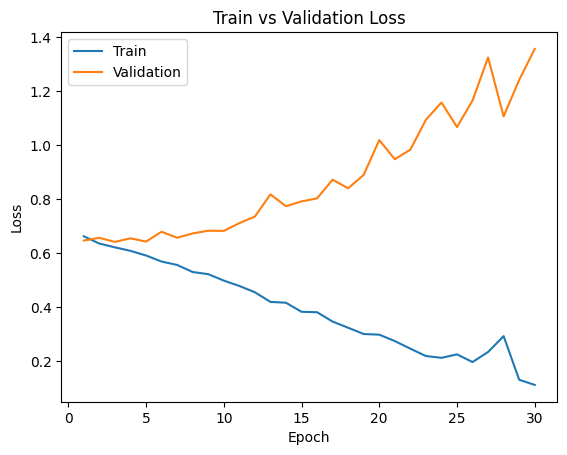

ANN Test error: 0.3705, Test loss: 1.2990


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a 2-layer ANN (similar to Lab1, but input size = 32*32*3 = 3072)
class ANN2Layer(nn.Module):
    def __init__(self, hidden_dim=128):
        super(ANN2Layer, self).__init__()
        self.name = "ann"
        self.layer1 = nn.Linear(32*32*3, hidden_dim)  # input size 3072
        self.layer2 = nn.Linear(hidden_dim, 1)        # binary output

    def forward(self, x):
        # Flatten RGB image (batch_size, 3, 32, 32) → (batch_size, 3072)
        x = x.view(-1, 32*32*3)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x.squeeze(1)  # flatten to [batch_size]

# Create network
ann_net = ANN2Layer(hidden_dim=128)

# Train using existing train_net function
train_net(ann_net, batch_size=64, learning_rate=0.01, num_epochs=30)

# Plot training curves
model_path_ann = get_model_name("ann", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_ann)

# Evaluate on test set
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ann_net, test_loader, criterion)
print(f"ANN Test error: {test_err:.4f}, Test loss: {test_loss:.4f}")


In [ ]:
"""
Compared to my best CNN model, in the 2-layer ANN, there is a larger divergence between training and validation performance.
This is a clear sign of overfitting data. The ANN memorizes the training datat but fails to generalize to unseen images.
In contrast the CNN achieved both lower training error and substantially lower validation error, demonstraiting better model.
"""

'\nCompared to my best CNN model, in the 2-layer ANN, there is a larger divergence between training and validation performance.\nThis is a clear sign of overfitting data. The ANN memorizes the training datat but fails to generalize to unseen images.\nIn contrast the CNN achieved both lower training error and substantially lower validation error, demonstraiting better model.\n'